In [2697]:
#パッケージをimort
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.datasets import load_iris
import sklearn.base as base
import sklearn.metrics as mt
import pandas as pd

In [2968]:
def normalize(data):
    return ((data-data.mean())/data.std()).copy()

In [2606]:
#base.BaseEstimator, base.ClassifierMixinを多重継承したPercepptronクラスを定義
class Perceptron(base.BaseEstimator, base.ClassifierMixin):
    """
    paramに必要な値
        rho:収束速度を決めるパラメータ
        margin:誤りの範囲を定めるマージン：0なら通常のパーセプトロン
        maxTrial:最大試行回数
    関数:
        fit:estimatorに必須．内部でtrainPerceptronUpdateかtrainPerceptronを呼ぶ
        predict:scoreを求めるのに必須．内部でpredictPerceptronを呼ぶ
        set_params:値のset(入力はdict)
        trainPerceptron:パーセプトロンを学習．
        trainPerceptronUpdate:パーセプトロンを学習．重み変更ごとに最大scoreとなる重みを求める
        predictPerceptron:学習した重みを用いて入力データのラベルを予測する．
    その他
        w:重み
    """
    def __init__(self,params):
        #parameterをdict形式で入力
        self.params=params
        self.set_params()

    def set_params(self):
        self.rho=self.params["rho"]
        self.margin=self.params["margin"]
        self.maxTrial=self.params["maxTrial"]
        #estimatorの要件でselfをreturn
        return self
    
    def fit(self, train, train_label):
        self.labels=train_label.unique()
        self.labels.sort()
        self.trainPerceptron(train,train_label)
        #estimatorの要件でselfをreturn
        return self
    
    def meaureScore(self, train, train_label, test, test_label):
        self.labels=train_label.unique()
        self.labels.sort()
        self.trainPerceptronMeaureScore(train,train_label, test, test_label)
        return self
    
    def predict(self, test):
        preds=self.predictPerceptron(test)
        return [self.labels[1 if pred else 0] for pred in preds]
        


    def trainPerceptron(self, train, train_label):
        #重み，学習データは定数項分の次元を加える
        self.w=np.ones(len(train.columns)+1)
        ones=np.array([np.ones(len(train.index))])
        X_values=np.concatenate((ones.T,train.values),axis=1)
        ansLabels=train_label.values
        misIdentified=True
        #試行回数
        trial=0
        #試行回数まではLoop,分離成功したら終了
        while misIdentified and trial<self.maxTrial:
            misIdentified=False
            #識別関数をデータ数分：行列演算で
            preds = self.w.dot(X_values.T)>0
            for i in range(len(train.index)):
                x=X_values[i]
                self.w.dot(x)
                isMargin=self.margin-np.abs(self.w.dot(x)/np.linalg.norm(self.w))>0
                #ラベルが一致していないかマージンが境界との距離を越えていないか
                if self.labels[1 if preds[i] else 0] != ansLabels[i]:
                    misIdentified=True
                    x=X_values[i]
                    #学習
                    if preds[i]:
                        self.w-=self.rho*x
                    else:
                        self.w+=self.rho*x
                    #値が発散しないように正規化する
                    self.w/=np.linalg.norm(self.w)
                elif isMargin:
                    misIdentified=True
                    x=X_values[i]
                    #学習
                    if not preds[i]:
                        self.w-=self.rho*x
                    else:
                        self.w+=self.rho*x
                    #値が発散しないように正規化する
                    self.w/=np.linalg.norm(self.w)
            trial+=1

    def predictPerceptron(self,test):
        #定数項を加える
        ones=np.array([np.ones(len(test.index))])
        X_values=np.concatenate((ones.T,test.values),axis=1)
        # g(x)>0
        preds= self.w.dot(X_values.T)>0
        return preds
    
    def trainPerceptronMeaureScore(self, train, train_label, test, test_label):
        #重み，学習データは定数項分の次元を加える
        self.w=np.ones(len(train.columns)+1)
        self.w/=np.linalg.norm(self.w)
        ones=np.array([np.ones(len(train.index))])
        X_values=np.concatenate((ones.T,train.values),axis=1)
        ansLabels=train_label.values
        misIdentified=True
        #試行回数
        trial=0
        #最大重みとsocore
        trainscore=self.score(train,train_label)
        testscore=self.score(test,test_label)
        max_w=[self.score(train,train_label),self.w]
        trainScores=[trainscore]
        testScores=[testscore]
        #試行回数まではLoop,分離成功したら終了
        while trial<self.maxTrial:
            misIdentified=False
            #識別関数をデータ数分：行列演算で
            preds= self.w.dot(X_values.T)>0
            for i in range(len(train.index)):
                x=X_values[i]
                self.w.dot(x)
                isMargin=True if self.margin==-1 else self.margin-np.abs(self.w.dot(x)/np.linalg.norm(self.w))>0
                #ラベルが一致していないかマージンが境界との距離を越えていないか
                if self.labels[1 if preds[i] else 0] != ansLabels[i]:
                    misIdentified=True
                    x=X_values[i]
                    #学習
                    if preds[i]:
                        self.w-=self.rho*x
                    else:
                        self.w+=self.rho*x
                    #値が発散しないように正規化する
                    self.w/=np.linalg.norm(self.w)
                elif isMargin:
                    misIdentified=True
                    x=X_values[i]
                    #学習
                    if not preds[i]:
                        self.w-=self.rho*x
                    else:
                        self.w+=self.rho*x
                    #値が発散しないように正規化する
                    self.w/=np.linalg.norm(self.w)
                #scoreを求めて，良いscoreなら最大重みとsocoreを更新
                trainscore=self.score(train,train_label)
                testscore=self.score(test,test_label)
                trainScores.append(trainscore)
                testScores.append(testscore)
                if max_w[0]<trainscore:
                    max_w[0]=trainscore
                    max_w[1]=self.w
                        
            trial+=1
        self.trainScores=trainScores
        self.testScores=testScores

In [2933]:
#base.BaseEstimator, base.ClassifierMixinを多重継承したPercepptronクラスを定義
class PerceptronExtend(base.BaseEstimator, base.ClassifierMixin):
    """
    関数:
        fit:estimatorに必須．内部でtrainPerceptronUpdateかtrainPerceptronを呼ぶ
        predict:scoreを求めるのに必須．内部でpredictPerceptronを呼ぶ
        trainPerceptron:パーセプトロンを学習:重心法
        predictPerceptron:学習した重みを用いて入力データのラベルを予測する．
    その他
        w:重み
    """
    
    def fit(self, train, train_label):
        self.labels=train_label.unique()
        self.labels.sort()
        self.trainPerceptron(train,train_label)
        #estimatorの要件でselfをreturn
        return self
    
    def predict(self, test):
        preds=self.predictPerceptron(test)
        return [self.labels[1 if pred else 0] for pred in preds]
        
    def trainPerceptron(self, train, train_label):
        ones=np.array([np.ones(len(train.index))])
        X_values=np.concatenate((ones.T,train.values),axis=1)
        w=-(X_values[train_label==self.labels[0]].mean(axis=0)-X_values[train_label==self.labels[1]].mean(axis=0))
        w/=np.linalg.norm(w)
        self.w=w

    def predictPerceptron(self,test):
        #定数項を加える
        ones=np.array([np.ones(len(test.index))])
        X_values=np.concatenate((ones.T,test.values),axis=1)
        # g(x)>0
        preds= self.w.dot(X_values.T)>0
        return preds

In [2476]:
#kakiデータを入力
kaki=pd.read_csv("sample/kaki.csv",dtype=float)
kaki["ans"]="kaki"
peanut=pd.read_csv("sample/peanut.csv",dtype=float)
peanut["ans"]="peanut"
kakiData=pd.concat([kaki,peanut],ignore_index=True)
#正規化（前処理）
kakiData.height=normalize(kakiData.height)
kakiData.width=normalize(kakiData.width)
kakiData.length=normalize(kakiData.length)
kakiLabels=["kaki","peanut"]

In [2416]:
#アヤメデータを使用する場合
irisdata=load_iris()

iris=pd.DataFrame(irisdata.data,columns=["sepalLength","sepalWidth","petelLength", "petelWidth"])
iris["ans"]=irisdata.target_names[irisdata.target]
irislabels=irisdata.target_names
#二値分類
def getIris2(iris,labels):
    labels.sort()
    iris_2=iris[(iris["ans"]==labels[0])|(iris["ans"]==labels[1])].reset_index(drop=True)
    #正規化
    iris_2.sepalLength=normalize(iris_2.sepalLength)
    iris_2.sepalWidth=normalize(iris_2.sepalWidth)
    iris_2.petelLength=normalize(iris_2.petelLength)
    iris_2.petelWidth=normalize(iris_2.petelWidth)
    return iris_2

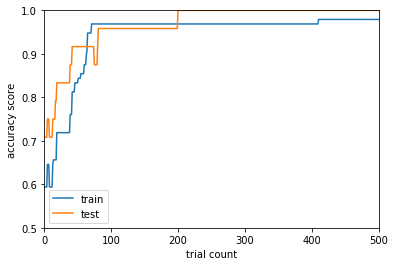

In [2967]:
#学習過程を得る
dataset=kakiData

train,test=train_test_split(dataset,test_size=0.2)
trainX,trainy=train.drop("ans",axis=1),train["ans"]
testX,testy=test.drop("ans",axis=1),test["ans"]

params={"rho":1e-2,"margin":0,"maxTrial":100}
perceptron=Perceptron(params)
perceptron.meaureScore(trainX,trainy,testX,testy)

plt.plot(perceptron.trainScores,label="train")
plt.plot(perceptron.testScores,label="test")
plt.ylim(0.5,1)
plt.xlim(0,500)
plt.ylabel("accuracy score")
plt.xlabel("trial count")
plt.legend()

In [2793]:
#扱うデータ
dataset=kakiData
#評価関数
scoring = {"precision": "precision_macro",
           "recall": "recall_macro",
           "f1": "f1_macro"}
#バリデーションにStratifiedKFoldを用いる,
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=None)
results=[]
margin_sets=np.linspace(0,1,20)
X,y=dataset.drop("ans",axis=1),dataset["ans"]
for margin in margin_sets:
    res=[]
    for i in range(10):
        #fitパラメータ
        params={"rho":1e-3,"margin":margin,"maxTrial":100}
        perceptron=Perceptron(params)
        result=cross_validate(perceptron, X, y, cv=skf, scoring=scoring)
        res.append(result)
    results.append(res)
mean_results={}
for key in results[0][0]:
    mean_results[key]=[]
for result in results:
    for key in mean_results:
        meanres=[]
        for r in result:
            meanres.append(r[key].mean())
        mean_results[key].append(np.array(meanres).mean())

mean_results["margin"]=margin_sets

(0.95, 1)

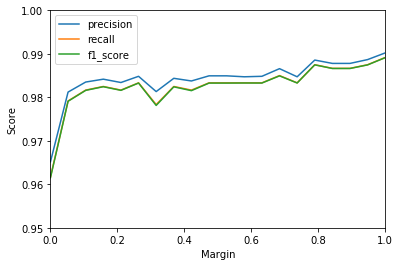

In [2797]:

%matplotlib inline
plt.plot(mean_results["margin"],mean_results["test_precision"],label="precision")
plt.plot(mean_results["margin"],mean_results["test_recall"],label="recall")
plt.plot(mean_results["margin"],mean_results["test_f1"],label="f1_score")
plt.legend()
plt.xlabel("Margin")
plt.ylabel("Score")
plt.xlim(0,max(margin_sets))
plt.ylim(0.95,1)

In [2788]:
#扱うデータ
dataset=getIris2(iris,irislabels[[0,1]])
#評価関数
scoring = {"precision": "precision_macro",
           "recall": "recall_macro",
           "f1": "f1_macro"}
#バリデーションにStratifiedKFoldを用いる,
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=None)
resultsirisA=[]
margin_sets=np.linspace(0,1,20)
X,y=dataset.drop("ans",axis=1),dataset["ans"]
for margin in margin_sets:
    res=[]
    for i in range(10):
        #fitパラメータ
        params={"rho":1e-3,"margin":margin,"maxTrial":100}
        perceptron=Perceptron(params)
        result=cross_validate(perceptron, X, y, cv=skf, scoring=scoring)
        res.append(result)
    resultsirisA.append(res)
mean_results={}
for key in resultsirisA[0][0]:
    mean_results[key]=[]
for result in resultsirisA:
    for key in mean_results:
        meanres=[]
        for r in result:
            meanres.append(r[key].mean())
        mean_results[key].append(np.array(meanres).mean())

mean_results["margin"]=margin_sets

(0.985, 1)

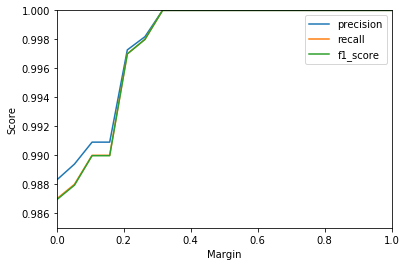

In [2792]:
plt.plot(mean_results["margin"],mean_results["test_precision"],label="precision")
plt.plot(mean_results["margin"],mean_results["test_recall"],label="recall")
plt.plot(mean_results["margin"],mean_results["test_f1"],label="f1_score")
plt.legend()
plt.xlabel("Margin")
plt.ylabel("Score")
plt.xlim(0,max(margin_sets))
plt.ylim(0.985,1)

In [2779]:
#扱うデータ
dataset=getIris2(iris,irislabels[[0,2]])
#評価関数
scoring = {"precision": "precision_macro",
           "recall": "recall_macro",
           "f1": "f1_macro"}
#バリデーションにStratifiedKFoldを用いる,
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=None)
resultsirisB=[]
margin_sets=np.linspace(0,1,20)
X,y=dataset.drop("ans",axis=1),dataset["ans"]
for margin in margin_sets:
    res=[]
    for i in range(10):
        #fitパラメータ
        params={"rho":1e-3,"margin":margin,"maxTrial":100}
        perceptron=Perceptron(params)
        result=cross_validate(perceptron, X, y, cv=skf, scoring=scoring)
        res.append(result)
    resultsirisB.append(res)
mean_results={}
for key in resultsirisB[0][0]:
    mean_results[key]=[]
for result in resultsirisB:
    for key in mean_results:
        meanres=[]
        for r in result:
            meanres.append(r[key].mean())
        mean_results[key].append(np.array(meanres).mean())

mean_results["margin"]=margin_sets

(0.98, 1)

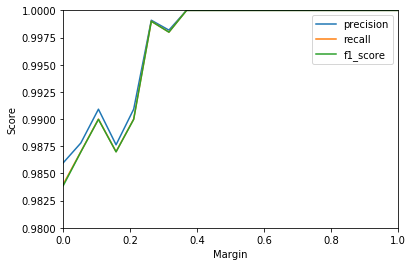

In [2784]:

plt.plot(mean_results["margin"],mean_results["test_precision"],label="precision")
plt.plot(mean_results["margin"],mean_results["test_recall"],label="recall")
plt.plot(mean_results["margin"],mean_results["test_f1"],label="f1_score")
plt.legend()
plt.xlabel("Margin")
plt.ylabel("Score")
plt.xlim(0,max(margin_sets))
plt.ylim(0.98,1)

In [2940]:
#扱うデータ
dataset=getIris2(iris,irislabels[[1,2]])
#評価関数
scoring = {"precision": "precision_macro",
           "recall": "recall_macro",
           "f1": "f1_macro"}
#バリデーションにStratifiedKFoldを用いる,
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=None)
resultsirisC=[]
margin_sets=np.linspace(0,2,20)
X,y=dataset.drop("ans",axis=1),dataset["ans"]
for margin in margin_sets:
    res=[]
    for i in range(10):
        #fitパラメータ
        params={"rho":5e-3,"margin":margin,"maxTrial":100}
        perceptron=Perceptron(params)
        result=cross_validate(perceptron, X, y, cv=skf, scoring=scoring)
        res.append(result)
    resultsirisC.append(res)
mean_results={}
for key in resultsirisC[0][0]:
    mean_results[key]=[]
for result in resultsirisC:
    for key in mean_results:
        meanres=[]
        for r in result:
            meanres.append(r[key].mean())
        mean_results[key].append(np.array(meanres).mean())

mean_results["margin"]=margin_sets

(0.9, 1)

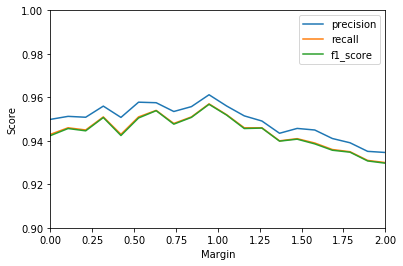

In [2942]:

plt.plot(mean_results["margin"],mean_results["test_precision"],label="precision")
plt.plot(mean_results["margin"],mean_results["test_recall"],label="recall")
plt.plot(mean_results["margin"],mean_results["test_f1"],label="f1_score")
plt.legend()
plt.xlabel("Margin")
plt.ylabel("Score")
plt.xlim(0,max(margin_sets))
plt.ylim(0.90,1)

In [2465]:
dataset=kakiData.sample(len(kakiData.index))
#全てのデータで学習    
params={"rho":5e-3,"margin":0,"maxTrial":1000}
perceptron=Perceptron(params)
X,y=dataset.drop("ans",axis=1),dataset["ans"]
perceptron.fit(X,y)
w=perceptron.w

<IPython.core.display.Javascript object>


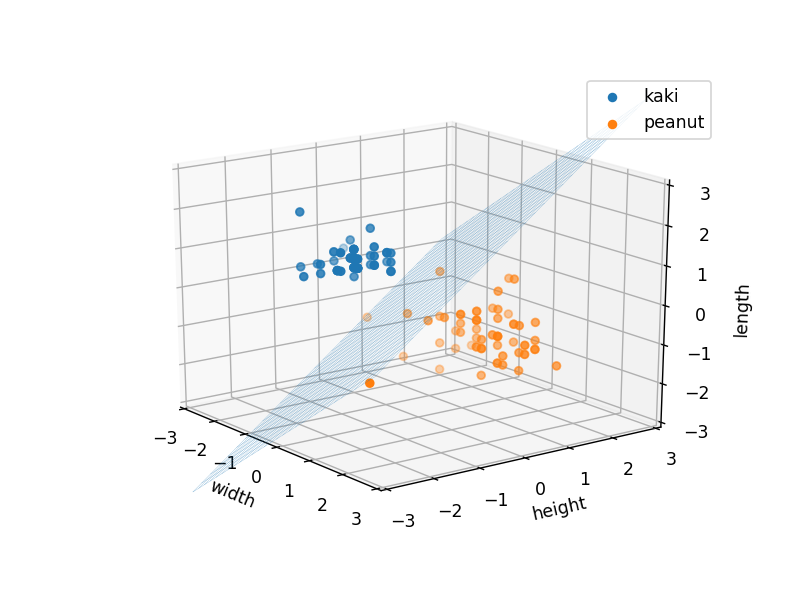

In [2466]:

#境界面
x = np.arange(-3,3, 0.2)
y = np.arange(-3, 3, 0.2)
X, Y = np.meshgrid(x, y)
Z=-1/w[1]*(w[0]+w[2]*X+w[3]*Y)

kaki=dataset[dataset["ans"]=="kaki"]
peanut=dataset[dataset["ans"]=="peanut"]

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(kaki.width, kaki.height, kaki.length,label="kaki")
ax.scatter3D(peanut.width, peanut.height, peanut.length,label="peanut")
ax.plot_wireframe(X,Y,Z,linewidth=0.1)
ax.set_xlabel("width")
ax.set_ylabel("height")
ax.set_zlabel("length")
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_zlim(-3,3)
plt.legend()
plt.show()

In [2934]:
#重心法による
#扱うデータ
dataset=getIris2(iris,irislabels[[1,2]])
#評価関数
scoring = {"precision": "precision_macro",
           "recall": "recall_macro",
           "f1": "f1_macro"}
#バリデーションにStratifiedKFoldを用いる,
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=None)
resultsirisC=[]
X,y=dataset.drop("ans",axis=1),dataset["ans"]
resultsExtend=[]
for i in range(10):
    #fitパラメータ
    perceptron=PerceptronExtend()
    result=cross_validate(perceptron, X, y, cv=skf, scoring=scoring)
    resultsExtend.append(result)

In [2935]:
mean_results={}
for key in resultsExtend[0]:
    mean_results[key]=[]
    
for key in mean_results:
    meanres=[]
    for result in resultsExtend:
        meanres.append(result[key].mean())
    mean_results[key].append(np.array(meanres).mean())